In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = False

In [2]:
import sys 
import os
sys.path.append('../')

from BackDiffuse_LT import BackDiffuse
from GetCoreData_fct import GetCoreData

In [3]:

from Interpolation_Class import Interpolation

In [4]:
site = 'SiteA'
DataAll = GetCoreData(site)

In [5]:
data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


In [38]:
gapMin = 76.3
gapMax = 76.5
gapL = gapMax - gapMin
gapIdx = np.where((data_d18O_LT['depth'] >= gapMin) & (data_d18O_LT['depth'] <= gapMax))

x = np.asarray(data_d18O_LT['depth'])
y = np.asarray(data_d18O_LT['d18O'])

xWgap = np.delete(x,gapIdx[0])
yWgap = np.delete(y,gapIdx[0])



In [39]:
interval = np.array([min(xWgap), max(xWgap)])
intervalGap = np.array([gapMin, gapMax])
interpTypeAll = 'CubicSpline'
interpGap = 'Linear'
inst = Interpolation(pd.Series(xWgap), pd.Series(yWgap), interval, interpTypeAll, GapInput=True, interpTypeGap=interpGap, gapInterval = intervalGap)

In [40]:
xHat, yHat, Delta = inst()
dataComb, dataGap, dataBelGap, dataAboGap = inst.interpolateDataAndGap()

Length of gap before interpolation: 0.20000000000000284
Length of gap after interpolation: 0.19


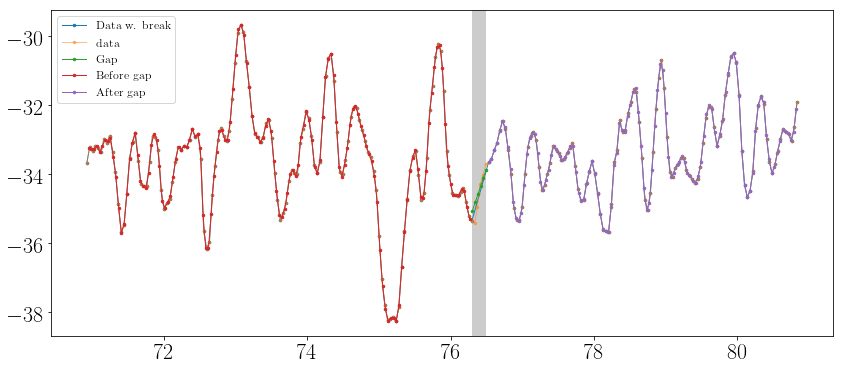

In [43]:
fig,ax = plt.subplots(figsize=(14,6))


plt.axvspan(gapMin,gapMax, facecolor='k', alpha=0.2)
plt.plot(xWgap, yWgap,'-',marker='.',lw=1, ms=5, label='Data w. break')

plt.plot(x,y,'-',marker='.',lw=1, ms=5, label='data',alpha=0.5)
#plt.plot(dataComb['depth'], dataComb['d18O'],'-',marker='.',color='k',lw=1, ms=5,label='All interp.')
plt.plot(dataGap['depth'], dataGap['d18O'], label='Gap', marker='.', lw=1, ms=5)
plt.plot(dataBelGap['depth'], dataBelGap['d18O'], label='Before gap', marker='.', lw=1, ms=5)
plt.plot(dataAboGap['depth'], dataAboGap['d18O'], label='After gap', marker='.', lw=1, ms=5)
plt.legend(fontsize=12)

gapMin_new = dataGap['depth'].values[0]
gapMax_new = dataGap['depth'].values[-1]
gapL_new = gapMax_new - gapMin_new

print(f'Length of gap before interpolation: {gapL}')
print(f'Length of gap after interpolation: {gapL_new:.2f}')

array([76.266, 76.304, 76.342, 76.38 , 76.418, 76.456, 76.494, 76.532])

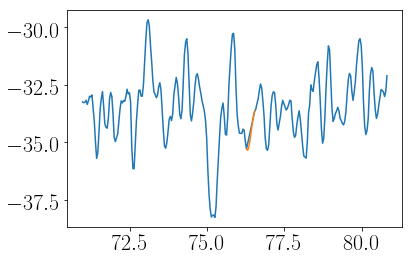

In [44]:
from scipy.interpolate import CubicSpline

xDataCS = np.concatenate((dataBelGap['depth'],dataAboGap['depth']), axis=0)
yDataCS = np.concatenate((dataBelGap['d18O'],dataAboGap['d18O']), axis=0)

delta = round(np.min(np.diff(xDataCS)),3)
f_interp = CubicSpline(xDataCS, yDataCS)

xtest = np.arange(dataBelGap['depth'][len(dataBelGap['depth'])-1],dataAboGap['depth'][0], delta)
ftest = f_interp(xtest)

plt.plot(xDataCS,yDataCS)
plt.plot(xtest,ftest)
xtest

In [45]:

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')
coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']


In [46]:
inst = BackDiffuse(site, dataComb, CoreSpecs, dTamb, dLaki, 32, diffLenData=data_diff[['Depth','sigma_o18']], densData=data_dens)
diffLen = inst.spectralEstimate()
difflenEstHL = inst.diffLenEstimateHL()
depth1, data, diffLen, peaks, arr_DiffLens, arr_Npeaks, arr_depth, arr_data = inst.backDiffused(theoDiffLen=True,print_Npeaks=False,interpAfterDecon=True,newDelta=0.02)

Starting sigma: 5.52 [cm]
Final sigma: 4.61 [cm]
Final # of peaks: 32


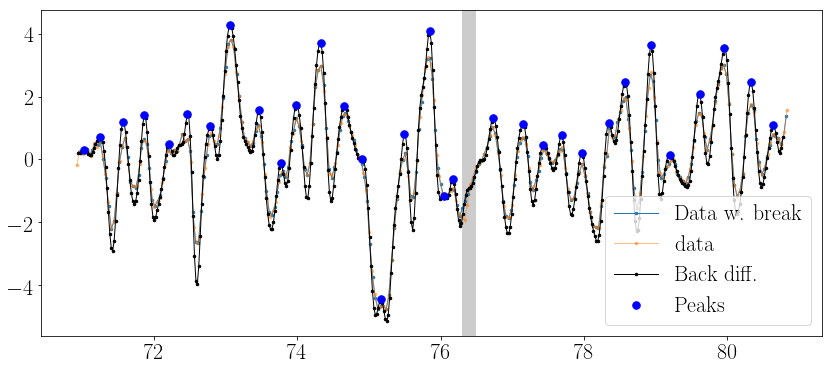

In [47]:
fig,ax = plt.subplots(figsize=(14,6))


plt.axvspan(gapMin,gapMax, facecolor='k', alpha=0.2)
plt.plot(dataComb['depth'],dataComb['d18O']-np.mean(dataComb['d18O']),'-',marker='.',lw=1, ms=5, label='Data w. break')

plt.plot(x,y-np.mean(y),'-',marker='.',lw=1, ms=5, label='data',alpha=0.5)
plt.plot(depth1,data,'-',marker='.',color='k',lw=1, ms=5,label='Back diff.')
plt.plot(depth1[peaks],data[peaks],'.',color='blue',lw=1, ms=15,label='Peaks')

plt.legend()